In [1]:
import numpy as np
import torch
import copy
import pandas as pd
import SimpleITK as sitk
from PIL import Image
# import pydicom
import cv2
import nibabel as nib
import os
import skimage.io as io

import matplotlib.pyplot as plt
# import plotly.graph_objects as go
# import plotly.express as px
# from func.model_arch import SegAirwayModel
from func.model_arch2 import SegAirwayModel

from sklearn.manifold import TSNE

import random
import h5py

from torch import from_numpy as from_numpy


import torchio as tio


/home/cs22-wangc/anaconda3/envs/test1/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

class Random3DCrop_np(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple)), 'Attention: random 3D crop output size: an int or a tuple (length:3)'
        if isinstance(output_size, int):
            self.output_size=(output_size, output_size, output_size)
        else:
            assert len(output_size)==3, 'Attention: random 3D crop output size: a tuple (length:3)'
            self.output_size=output_size
        
    def random_crop_start_point(self, input_size):
        assert len(input_size)==3, 'Attention: random 3D crop output size: a tuple (length:3)'
        d, h, w=input_size
        d_new, h_new, w_new=self.output_size
        
        d_new = min(d, d_new)
        h_new = min(h, h_new)
        w_new = min(w, w_new)
        
        assert (d>=d_new and h>=h_new and w>=w_new), "Attention: input size should >= crop size; now, input_size is "+str((d,h,w))+", while output_size is "+str((d_new, h_new, w_new))
        
        d_start=np.random.randint(0, d-d_new+1)
        h_start=np.random.randint(0, h-h_new+1)
        w_start=np.random.randint(0, w-w_new+1)
        
        return d_start, h_start, w_start
    
    def __call__(self, img_3d, start_points=None):
        img_3d=np.array(img_3d)
        
        d, h, w=img_3d.shape
        d_new, h_new, w_new=self.output_size
        
        if start_points == None:
            start_points = self.random_crop_start_point(img_3d.shape)
        
        d_start, h_start, w_start = start_points
        d_end = min(d_start+d_new, d)
        h_end = min(h_start+h_new, h)
        w_end = min(w_start+w_new, w)
        
        crop=img_3d[d_start:d_end, h_start:h_end, w_start:w_end]
        
        return crop

class Normalization_np(object):
    def __init__(self, windowMin, windowMax):
        self.name = 'ManualNormalization'
        assert isinstance(windowMax, (int,float))
        assert isinstance(windowMin, (int,float))
        self.windowMax = windowMax
        self.windowMin = windowMin
    
    def __call__(self, img_3d):
        img_3d_norm = np.clip(img_3d, self.windowMin, self.windowMax)
        img_3d_norm-=np.min(img_3d_norm)
        max_99_val=np.percentile(img_3d_norm, 99)
        if max_99_val>0:
            img_3d_norm = img_3d_norm/max_99_val*255
        return img_3d_norm
crop_size = (32, 128, 128)
windowMin=-1000
windowMax=150
random3dcrop=Random3DCrop_np(crop_size)
normalization=Normalization_np(windowMin, windowMax)

In [ ]:
test_img='/mnt/share102/cs22-wangc/EXACT09/EXACT09_3D/train/CASE01.nii.gz'
img = io.imread(test_img, plugin='simpleitk')
N=0
# ----------

plt.figure(figsize=(8,6))
plt.title("raw image with model output label")
plt.imshow(img[N,:,:], cmap='gray')

In [ ]:
start_points = random3dcrop.random_crop_start_point(img.shape)  # 起点
raw_img_crop = random3dcrop(np.array(img, float), start_points=start_points)
raw_img_crop = normalization(raw_img_crop)
plt.figure(figsize=(8,6))
plt.title("raw image and shape is"+str(raw_img_crop.shape))
plt.imshow(raw_img_crop[N,:,:], cmap='gray')

In [ ]:
np.set_printoptions(threshold=np.inf, linewidth=np.inf, suppress=True, precision=1)

# print(img)
print(raw_img_crop.shape)
print(raw_img_crop[N,:,:])
#

In [3]:
Precrop_dataset_for_train_path = "/mnt/share102/cs22-wangc/EXACT09/Precrop_dataset_for_EXACT091"
# Precrop_dataset_for_train_path = "/mnt/share102/cs22-wangc/EXACT09/Cluster/cluster1"

Precrop_dataset_for_train_raw_path = Precrop_dataset_for_train_path+"/image"
Precrop_dataset_for_train_label_path = Precrop_dataset_for_train_path+"/label"
raw_case_name_list = os.listdir(Precrop_dataset_for_train_raw_path)


In [5]:
import os
import matplotlib.pyplot as plt
from skimage import io

def show_all_2d_img_with_labels(raw_img_path, output_folder, img_num=None, 
                                num_images_per_batch=16, slice_index=20, label_path=None):
    raw_img_list = os.listdir(raw_img_path)
    if img_num is None:
        img_num = len(raw_img_list)
    img_num = min(img_num, len(raw_img_list))
    num_batches = (img_num + num_images_per_batch - 1) // num_images_per_batch  # 上取整

    num_rows = 4
    num_cols = 4
    
    # 检查并创建输出文件夹
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    for batch_num in range(num_batches):
        start_index = batch_num * num_images_per_batch
        end_index = min((batch_num + 1) * num_images_per_batch, img_num)
        
        img_list = []
        for i in range(start_index, end_index):
            raw_img_addr = os.path.join(raw_img_path, raw_img_list[i])
            raw_img = io.imread(raw_img_addr, plugin='simpleitk')
            img_list.append(raw_img)
            print(f'img_selecting {100 * (i+1) / img_num:.2f}%', end='\r')
        
        # 创建一个包含16个子图的图像窗口
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20))
        fig.suptitle(f"Batch {batch_num+1} - Raw Images")
        
        for i in range(num_rows):
            for j in range(num_cols):
                index = i * num_cols + j
                if index < len(img_list):
                    raw_img = img_list[index]
                    ax = axes[i, j]
                    
                    ax.imshow(raw_img[slice_index, :, :], cmap='gray')
                    
                    if label_path is not None:
                        label_img_addr = os.path.join(label_path, raw_img_list[index])
                        label_img = io.imread(label_img_addr, plugin='simpleitk')
                        if 1 not in label_img[slice_index, :, :]:
                            print("no label ")
                        ax.contour(label_img[slice_index, :, :], colors='r', linestyles='-')
                    
                    ax.set_title(f"img_list index {index}")
                    ax.axis('off')
        
        # 调整子图之间的间距和布局
        plt.subplots_adjust(wspace=0.1, hspace=0.3)
        
        # 保存图像
        plt.savefig(os.path.join(output_folder, f"label_{batch_num+1}.png"))
        
        # 关闭图像窗口，避免重叠
        plt.close()

In [6]:
import os
import matplotlib.pyplot as plt
from skimage import io

def show_all_2d_img_with_labels(raw_img_path, output_folder, img_num=None, 
                                num_images_per_batch=16, slice_index=20, label_path=None):
    raw_img_list = os.listdir(raw_img_path)
    if img_num is None:
        img_num = len(raw_img_list)
    img_num = min(img_num, len(raw_img_list))
    num_batches = (img_num + num_images_per_batch - 1) // num_images_per_batch  # 上取整

    num_rows = 4
    num_cols = 4
    
    # 检查并创建输出文件夹
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    for batch_num in range(num_batches):
        start_index = batch_num * num_images_per_batch
        end_index = min((batch_num + 1) * num_images_per_batch, img_num)
        
        img_list = []
        label_list = []  # 新增：用于存储标签图像
        
        for i in range(start_index, end_index):
            raw_img_addr = os.path.join(raw_img_path, raw_img_list[i])
            raw_img = io.imread(raw_img_addr, plugin='simpleitk')
            img_list.append(raw_img)
            
            if label_path is not None:
                label_img_list=os.listdir(label_path)
                label_img_addr = os.path.join(label_path, label_img_list[i])  # 使用相同的索引加载标签图像
                label_img = io.imread(label_img_addr, plugin='simpleitk')
                label_list.append(label_img)  # 存储标签图像
        
        # 创建一个包含16个子图的图像窗口
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20))
        fig.suptitle(f"Batch {batch_num+1} - Raw Images")
        
        for i in range(num_rows):
            for j in range(num_cols):
                index = i * num_cols + j
                if index < len(img_list):
                    raw_img = img_list[index]
                    ax = axes[i, j]

                    ax.imshow(raw_img[slice_index, :, :], cmap='gray')

                    if label_path is not None:
                        label_img = label_list[index]  # 使用相应索引的标签图像
                        if 1 not in label_img[slice_index, :, :]:
                            ax.text(0.8, 0.9, "No Label", transform=ax.transAxes, color='r', fontsize=12, fontweight='bold')
                        ax.contour(label_img[slice_index, :, :], colors='r', linestyles='-')

                    ax.set_title(f"img_list index {index}")
                    ax.axis('off')
        
        # 调整子图之间的间距和布局
        plt.subplots_adjust(wspace=0.1, hspace=0.3)
        
        # 保存图像
        plt.savefig(os.path.join(output_folder, f"label_{batch_num+1}.png"))
        
        # 关闭图像窗口，避免重叠
        plt.close()

In [ ]:
import os
import matplotlib.pyplot as plt
from skimage import io
from matplotlib import gridspec

def show_all_2d_img_with_labels(raw_img_path, output_folder, img_num=None, 
                                num_images_per_batch=16, slice_index=20, label_path=None,raw_img_list=None):
    if raw_img_list is None:
        raw_img_list = os.listdir(raw_img_path)
    if img_num is None:
        img_num = len(raw_img_list)
    img_num = min(img_num, len(raw_img_list))
    num_batches = (img_num + num_images_per_batch - 1) // num_images_per_batch  # 上取整

    num_rows = 4
    num_cols = 4
    
    # 检查并创建输出文件夹
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    for batch_num in range(num_batches):
        start_index = batch_num * num_images_per_batch
        end_index = min((batch_num + 1) * num_images_per_batch, img_num)
        
        img_list = []
        label_list = []  # 新增：用于存储标签图像

        img_names=[]
        label_names=[]
        
        for i in range(start_index, end_index):
            raw_img_addr = os.path.join(raw_img_path, raw_img_list[i])
            raw_img = io.imread(raw_img_addr, plugin='simpleitk')
            img_list.append(raw_img)

            img_names.append(raw_img_list[i])
            
            if label_path is not None:
                label_img_list = os.listdir(label_path)
                label_img_addr = os.path.join(label_path, label_img_list[i])  # 使用相同的索引加载标签图像
                label_img = io.imread(label_img_addr, plugin='simpleitk')
                label_list.append(label_img)  # 存储标签图像

                label_names.append(label_img_list[i])
        
        # 创建一个包含16个子图的图像窗口，使用gridspec布局
        fig = plt.figure(figsize=(20, 20))
        gs = gridspec.GridSpec(num_rows, num_cols, figure=fig)
        fig.suptitle(f"Batch {batch_num+1} - Raw Images")
        
        for i in range(num_rows):
            for j in range(num_cols):
                index = i * num_cols + j
                if index < len(img_list):
                    raw_img = img_list[index]
                    ax = fig.add_subplot(gs[i, j])

                    ax.imshow(raw_img[slice_index, :, :], cmap='gray')

                    if label_path is not None:
                        label_img = label_list[index]  # 使用相应索引的标签图像
                        if 1 not in label_img[slice_index, :, :]:
                            ax.text(0.8, 0.9, "No Label", transform=ax.transAxes, color='b', fontsize=12, fontweight='bold')
                        ax.contour(label_img[slice_index, :, :], colors='r', linestyles='-')
                        
                    ax.set_title(f"Image {img_names[index]}\nLabel {label_names[index]} ")
                    ax.axis('off')
        
        # 调整子图之间的间距和布局
        plt.tight_layout()
        
        # 保存图像
        plt.savefig(os.path.join(output_folder, f"exact09_cluster_{batch_num+1}.png"))
        
        # 关闭图像窗口，避免重叠
        plt.close()


In [ ]:
raw_img_p = 'EXACT09_CASE15_347.nii.gz'
raw_img_path = '/mnt/share102/cs22-wangc/EXACT09/Precrop_dataset_for_EXACT091/image'
raw_img_addr = os.path.join(raw_img_path, raw_img_p)
raw_img = io.imread(raw_img_addr, plugin='simpleitk')

label_path = '/mnt/share102/cs22-wangc/EXACT09/Precrop_dataset_for_EXACT091/label'
label_img_addr = os.path.join(label_path, raw_img_p)
label_img = io.imread(label_img_addr, plugin='simpleitk')



num_slices = 16  # 总共的切片数量
num_rows = 4
num_cols = 4

plt.figure(figsize=(15, 15))

for i in range(num_slices):
    index=i+num_slices*0
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(raw_img[index, :, :], cmap='gray')
    plt.contour(label_img[index, :, :], colors='r', linestyles='-')
    plt.title(f'Slice {index}')
    plt.axis('off')

plt.tight_layout()
plt.show()
# print(raw_img.shape)

In [10]:
all_path = '/mnt/share102/cs22-wangc/EXACT09/sec_Cluster'

# 使用 os.listdir 获取指定文件夹中的所有子文件夹名称
sub_folders = [folder_name for folder_name in os.listdir(all_path) if os.path.isdir(os.path.join(all_path, folder_name))]

print(sub_folders)  

['class1', 'class0']


In [103]:
import random
i = 0
N=2000
slice_num=20
img_list=[]
label_list=[]
for i in range(len(raw_case_name_list)):
    if i < N:
        i += 1
        random_index = random.randint(0, len(raw_case_name_list) - 1)
        name=raw_case_name_list[random_index]
        img_addr = Precrop_dataset_for_train_raw_path + "/" + name
        label_addr=Precrop_dataset_for_train_label_path+ "/" + name
        # print(f'this is {i}')
        img = io.imread(img_addr, plugin='simpleitk')
        gt=io.imread(label_addr, plugin='simpleitk')
        # start_points = random3dcrop.random_crop_start_point(img.shape)  # 起点
        # raw_img_crop = random3dcrop(np.array(img, float), start_points=start_points)
        # raw_img_crop = normalization(raw_img_crop)
        img_list.append(img)
        label_list.append(gt)

        # raw_img_crop = np.expand_dims(raw_img_crop, axis=0)

        # b = from_numpy(raw_img_crop).float()
        # b = b.unsqueeze(0).to(device)
        # embeddings = model.get_embedding(b)
        # emb3=embeddings[3].cpu().detach().numpy()
        # embeddings_list.append(emb3)  # 移动到CPU并转为NumPy后添加到列表
        # embeddings_dict[name] = emb3
        # del b

# # 将列表中的NumPy数组堆叠成一个NumPy数组
# stacked_embeddings_numpy = np.stack(embeddings_list, axis=0)
# print(stacked_embeddings_numpy.shape)  # 输出应为 [N, 256, 4, 16, 16]



In [ ]:
random_index = random.randint(0, len(img_list) - 1)
temp=img_list[random_index]
slice_num=8
# raw_img_adrr=Precrop_dataset_for_train_raw_path = Precrop_dataset_for_train_path+"/image/"+'EXACT09_CASE11_118.nii.gz'
# temp = io.imread(raw_img_adrr, plugin='simpleitk')
# 定义图像排列的行数和列数

num_rows = 4
num_cols = 4

# 创建一个包含32个子图的图像窗口
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20))

# 设置图像窗口的标题
fig.suptitle("Raw Images")

# 循环遍历每个子图，并在其中显示对应的图像
for i in range(num_rows):
    for j in range(num_cols):
        index = i * num_cols + j
        temp=img_list[index]
        if slice_num < raw_img_crop.shape[0]:
            axes[i, j].imshow(temp[slice_num, :, :], cmap='gray')
            axes[i, j].set_title(f"img_list index {index}")
            axes[i, j].axis('off')  # 不显示坐标轴

# # 调整子图之间的间距和布局
# plt.subplots_adjust(wspace=0.01, hspace=0.003)

# 显示图像
plt.show()

In [ ]:
# 设置打印选项，使浮点数以固定的小数位数形式显示，小数位数为1
np.set_printoptions(threshold=np.inf, linewidth=np.inf, suppress=True, precision=1)
print(raw_img_crop[slice_num,:,:].sum())
print(raw_img_crop[slice_num,:,:])

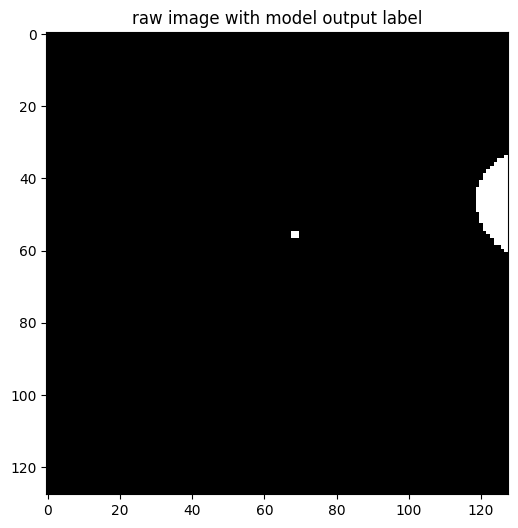

In [39]:
# choose the slice to show
# ----------

# ----------

plt.figure(figsize=(8,6))
plt.title("raw image with model output label")
plt.imshow(img[slice_num,:,:], cmap='gray')
# plt.contour(seg_onehot_comb[N,:,:], colors='r', linestyles='-')